### Angel Guillermo Lopez Delgado
**Dataset:** EPL Player Stats 2024-2025

Importar librerías

In [10]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt

Cargar datos

In [11]:
df = pd.read_csv('epl_player_stats_24_25.csv')
df.head()

,Player Name,Club,Nationality,Position,Appearances,Minutes,Goals,Assists,Shots,Shots On Target,...,Fouls,Yellow Cards,Red Cards,Saves,Saves %,Penalties Saved,Clearances Off Line,Punches,High Claims,Goals Prevented
0,Ben White,Arsenal,England,DEF,17,1198,0,2,9,12,...,10,2,0,0,0%,0,0,0,0,0.0
1,Bukayo Saka,Arsenal,England,MID,25,1735,6,10,67,2,...,15,3,0,0,0%,0,0,0,0,0.0
2,David Raya,Arsenal,Spain,GKP,38,3420,0,0,0,0,...,1,3,0,86,72%,0,0,8,53,2.1
3,Declan Rice,Arsenal,England,MID,35,2833,4,7,48,18,...,21,5,1,0,0%,0,0,0,0,0.0
4,Ethan Nwaneri,Arsenal,England,MID,26,889,4,0,24,0,...,9,1,0,0,0%,0,0,0,0,0.0


Preprocesamiento

Eliminar columnas no numéricas irrelevantes

In [12]:
df = df.drop(['Player Name', 'Club', 'Nationality'], axis=1)
for col in df.columns:
    if df[col].dtype == 'object' and df[col].str.contains('%').any():
        df[col] = df[col].str.replace('%', '', regex=False).astype(float)

X = df.drop('Position', axis=1)
X = X.apply(pd.to_numeric, errors='coerce')  # convierte errores a NaN
X = X.fillna(0)  # reemplazar NaN con 0

variable objetivo

In [13]:
le = LabelEncoder()
df['Position'] = le.fit_transform(df['Position'])
y = df['Position']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Escalar

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

MLPClassifier

In [15]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'activation': ['relu', 'tanh']
}

mlp = MLPClassifier(max_iter=1000, random_state=42)
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)


Mejores hiperparámetros: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


Evaluación

In [16]:
y_pred = grid_search.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión en conjunto de prueba: {accuracy:.4f}')
print("Reporte de clasificación: ", classification_report(y_test, y_pred, target_names=le.classes_))

Precisión en conjunto de prueba: 0.7257
Reporte de clasificación:                precision    recall  f1-score   support

         DEF       0.89      0.79      0.84        43
         FWD       0.47      0.56      0.51        16
         GKP       0.88      0.88      0.88         8
         MID       0.67      0.70      0.68        46

    accuracy                           0.73       113
   macro avg       0.73      0.73      0.73       113
weighted avg       0.74      0.73      0.73       113



Matriz de confusión

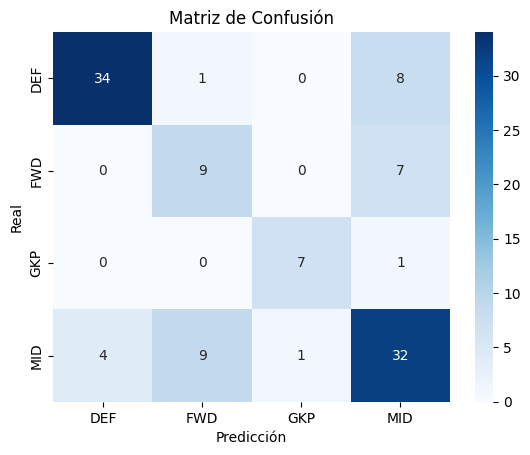

In [17]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Comparación con modelo

In [18]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_scaled, y_train)
y_pred_tree = tree.predict(X_test_scaled)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f'Precisión Árbol de Decisión: {accuracy_tree:.4f}')

Precisión Árbol de Decisión: 0.6903


Análisis de errores

In [19]:
error_mask = y_pred != y_test
X_errors = pd.DataFrame(X_test_scaled[error_mask], columns=X.columns)
y_true_errors = y_test[error_mask].reset_index(drop=True)
y_pred_errors = pd.Series(y_pred[error_mask]).reset_index(drop=True)

y_true_errors_labels = le.inverse_transform(y_true_errors)
y_pred_errors_labels = le.inverse_transform(y_pred_errors)

Crear DataFrame con errores

In [20]:
error_df = X_errors.copy()
error_df["Real Position"] = y_true_errors_labels
error_df["Predicted Position"] = y_pred_errors_labels
error_df.reset_index(drop=True, inplace=True)
print("Primeros 10 errores de clasificación:")
error_df.head(10)

Primeros 10 errores de clasificación:


,Appearances,Minutes,Goals,Assists,Shots,Shots On Target,Conversion %,Big Chances Missed,Hit Woodwork,Offsides,...,Red Cards,Saves,Saves %,Penalties Saved,Clearances Off Line,Punches,High Claims,Goals Prevented,Real Position,Predicted Position
0,-0.621800,-0.414448,0.076104,-0.51606,0.210659,-0.154028,0.823060,-0.313436,-0.500523,-0.319122,...,-0.302907,-0.227240,-0.226655,-0.143019,-0.313119,-0.17186,-0.215075,-0.123487,FWD,MID
1,-1.593170,-1.262176,-0.518167,-0.51606,-0.783617,-0.586945,-0.625655,-0.567009,-0.500523,-0.554403,...,-0.302907,-0.227240,-0.226655,-0.143019,-0.313119,-0.17186,-0.215075,-0.123487,DEF,MID
2,-1.512222,-1.245371,-0.518167,-0.51606,-0.783617,-0.586945,-0.625655,-0.567009,-0.500523,-0.554403,...,-0.302907,-0.227240,-0.226655,-0.143019,-0.313119,-0.17186,-0.215075,-0.123487,MID,FWD
3,0.511466,-0.416316,0.373239,-0.51606,0.297118,1.902328,1.744969,0.954428,-0.500523,0.151439,...,-0.302907,-0.227240,-0.226655,-0.143019,-0.313119,-0.17186,-0.215075,-0.123487,MID,FWD
4,-0.702747,-1.137071,-0.518167,-0.51606,-0.610699,-0.586945,-0.625655,-0.567009,0.480852,-0.554403,...,-0.302907,-0.227240,-0.226655,-0.143019,-0.313119,-0.17186,-0.215075,-0.123487,MID,FWD
5,-1.350327,-1.246304,-0.518167,-0.51606,-0.783617,-0.586945,-0.625655,-0.567009,-0.500523,-0.554403,...,-0.302907,-0.227240,-0.226655,-0.143019,-0.313119,-0.17186,-0.215075,-0.123487,MID,FWD
6,0.106728,-0.276273,-0.518167,-0.51606,-0.481011,-0.478716,-0.625655,-0.567009,-0.500523,-0.554403,...,-0.302907,-0.227240,-0.226655,-0.143019,-0.313119,-0.17186,-0.215075,-0.123487,DEF,MID
7,-1.026537,-0.937276,-0.518167,-0.51606,-0.783617,-0.586945,-0.625655,-0.567009,-0.500523,-0.554403,...,-0.302907,-0.227240,-0.226655,-0.143019,-0.313119,-0.17186,-0.215075,-0.123487,DEF,MID
8,-0.621800,-0.174508,-0.518167,-0.51606,-0.783617,-0.586945,-0.625655,-0.567009,-0.500523,-0.554403,...,-0.302907,2.042354,3.817115,-0.143019,-0.313119,-0.17186,2.993185,-3.569254,MID,GKP
9,1.078098,1.374368,0.967510,-0.51606,0.902329,0.711806,0.954761,0.954428,0.480852,-0.319122,...,2.860006,-0.227240,-0.226655,-0.143019,-0.313119,-0.17186,-0.215075,-0.123487,MID,DEF


Gráfico de errores

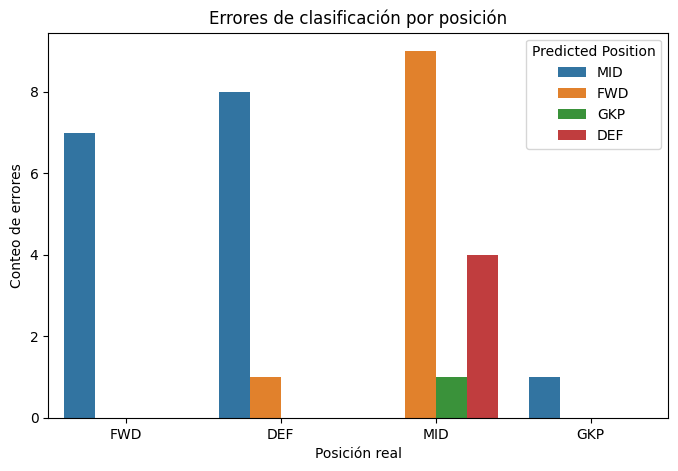

In [21]:
plt.figure(figsize=(8, 5))
sns.countplot(x="Real Position", hue="Predicted Position", data=error_df)
plt.title("Errores de clasificación por posición")
plt.xlabel("Posición real")
plt.ylabel("Conteo de errores")
plt.show()


Visualización de errores

In [22]:
mask = y_test.isin([1, 2]) 

Filtrar subconjunto

In [23]:
X_sel = pd.DataFrame(X_test_scaled[mask], columns=X.columns).reset_index(drop=True)
y_true_sel = y_test[mask].reset_index(drop=True)
y_pred_sel = pd.Series(y_pred[mask]).reset_index(drop=True)

error_mask = y_pred_sel != y_true_sel
X_sel = X_sel[error_mask].reset_index(drop=True)
y_true_sel = y_true_sel[error_mask].reset_index(drop=True)
y_pred_sel = y_pred_sel[error_mask].reset_index(drop=True)

y_true_sel_labels = le.inverse_transform(y_true_sel)
y_pred_sel_labels = le.inverse_transform(y_pred_sel)

Visualizar errores (como texto)

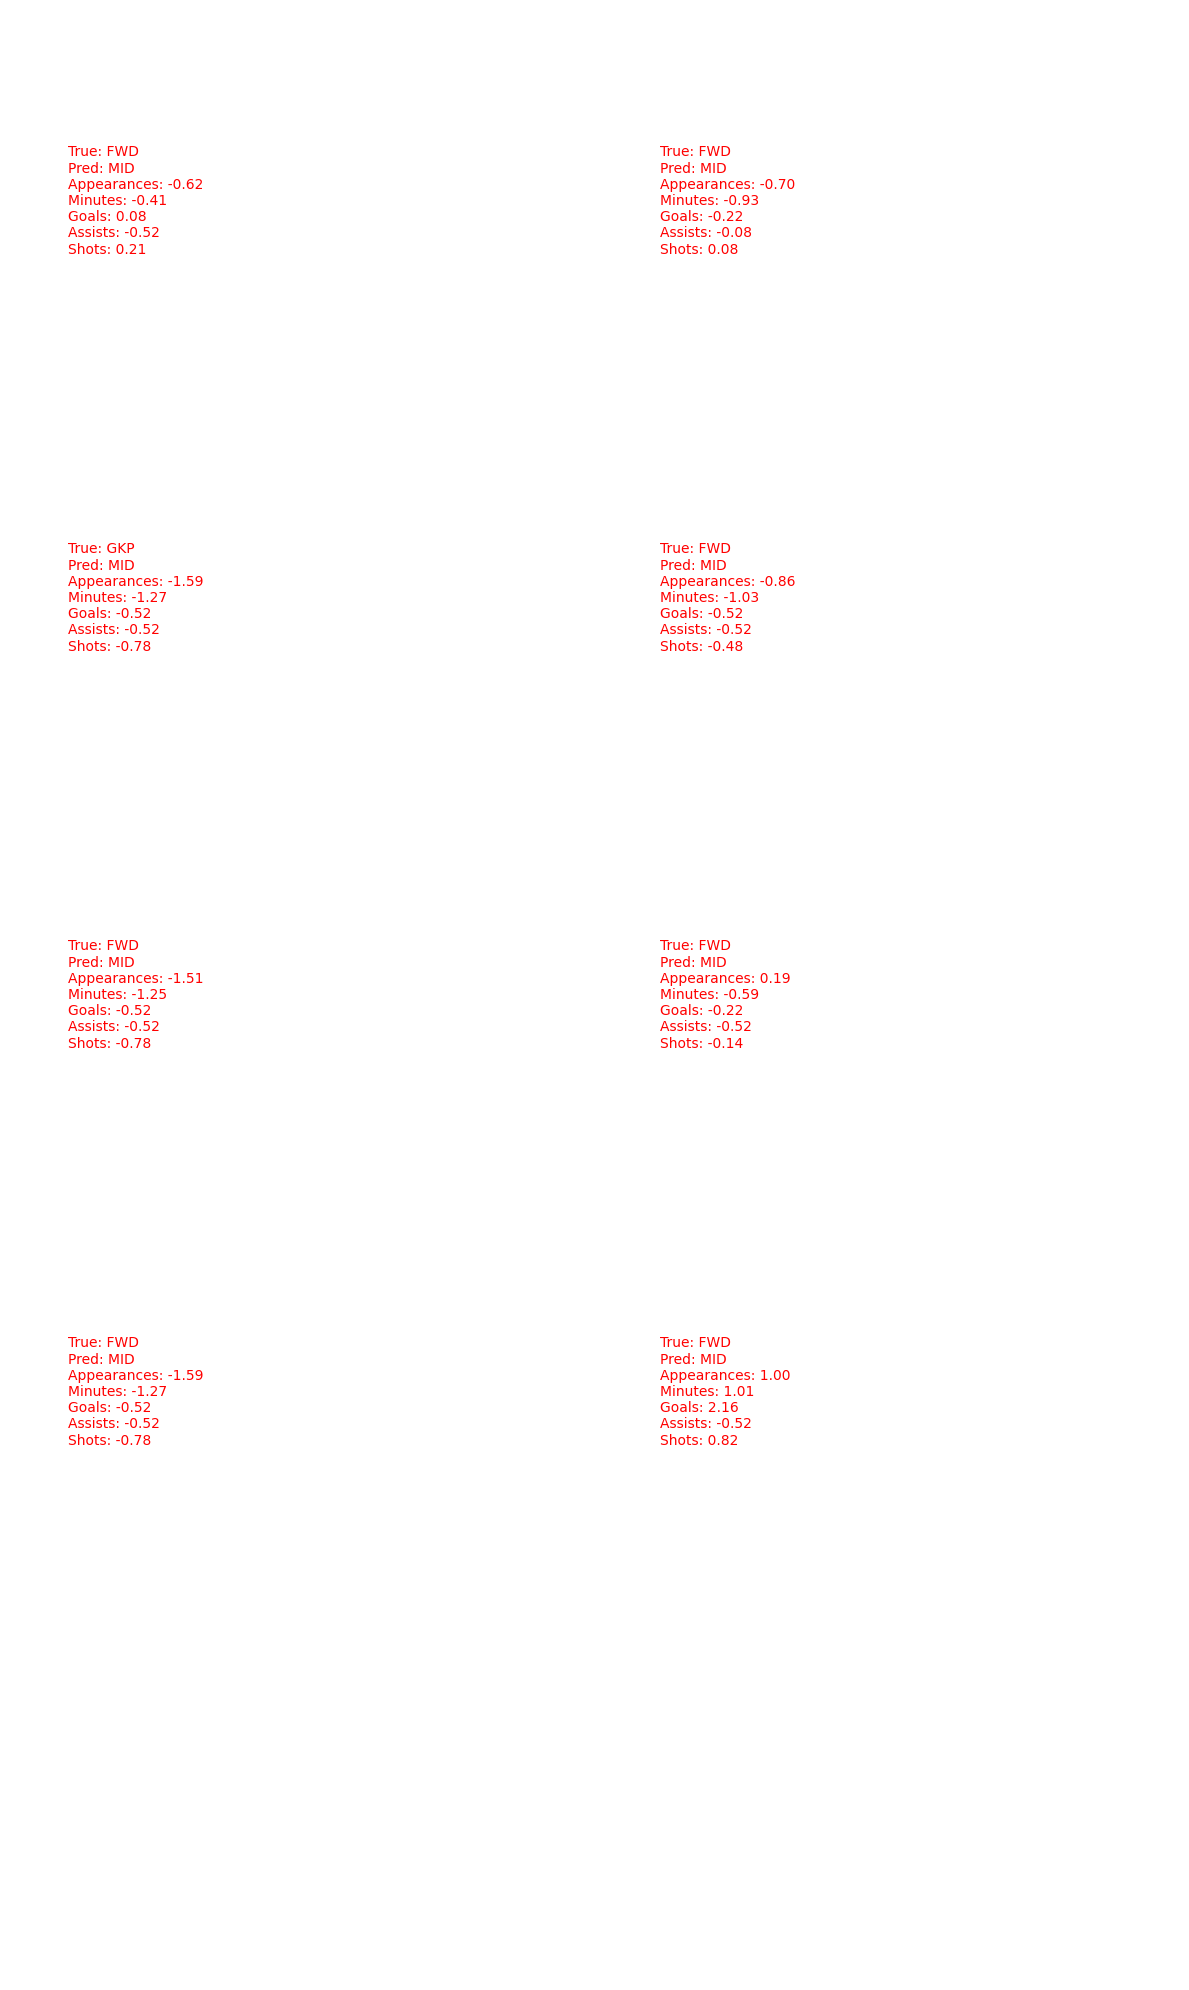

In [24]:
fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 10 errores por ejemplo
axes = axes.flat

for i, ax in enumerate(axes):
    if i >= len(X_sel):
        ax.axis('off')
        continue
    
    stats = X_sel.iloc[i]
    true_label = y_true_sel_labels[i]
    pred_label = y_pred_sel_labels[i]
    
    # Texto a mostrar
    text = f"True: {true_label}\nPred: {pred_label}\n"
    text += "\n".join([f"{col}: {val:.2f}" for col, val in stats.items()][:5])  # muestra 5 stats
    
    color = 'red' if true_label != pred_label else 'green'
    ax.text(0.1, 0.5, text, fontsize=10, color=color, va='center', ha='left', wrap=True)
    ax.set_axis_off()

plt.tight_layout()
plt.show()